In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statistics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets
from sklearn.linear_model import LinearRegression

## Data Understanding

In [11]:
set2_df = pd.read_csv(r'../data/set9_it2CLEANED.csv')
set3_df = pd.read_csv(r'../data/set9_it3.csv')

In [13]:
# New dataframe info
print(set3_df.info())
print(set3_df.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   DI              2363 non-null   int64
 1   Craftsmanship   2363 non-null   int64
 2   EraConstructed  2363 non-null   int64
dtypes: int64(3)
memory usage: 55.5 KB
None
   DI  Craftsmanship  EraConstructed
0   0              5            1466


In [7]:
# Checking for missing values
print(set3_df.isna().sum())

DI                0
Craftsmanship     0
EraConstructed    0
dtype: int64


In [5]:
# Min/max values for numeric rows
minCraftsmanship = str(set3_df['Craftsmanship'].min())
maxCraftsmanship = str(set3_df['Craftsmanship'].max())

minEraConstructed = str(set3_df['EraConstructed'].min())
maxEraConstructed = str(set3_df['EraConstructed'].max())

print(f"""
Craftsmanship: {minCraftsmanship} - {maxCraftsmanship}
EraConstructed: {minEraConstructed} - {maxEraConstructed}
""")


Craftsmanship: 1 - 10
EraConstructed: 887 - 1799



In [8]:
# Amount of houses by craftsmanship
set3_df['Craftsmanship'].value_counts()

Craftsmanship
5     667
6     577
7     498
8     276
4     183
9      95
3      31
10     26
2       9
1       1
Name: count, dtype: int64

<Axes: xlabel='Craftsmanship', ylabel='Count'>

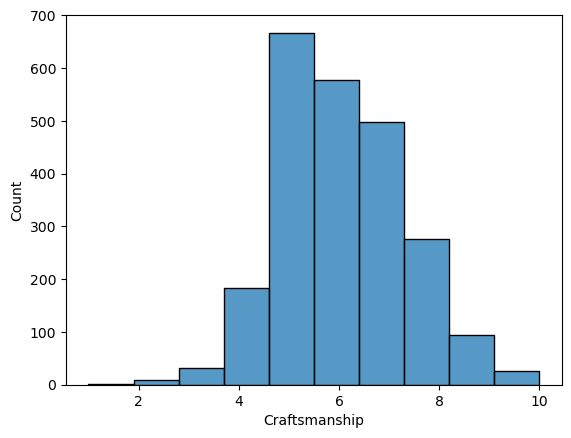

In [9]:
# Craftsmanship and EraConstructed distributions
sns.histplot(set3_df['Craftsmanship'], bins=10)

<Axes: xlabel='EraConstructed', ylabel='Count'>

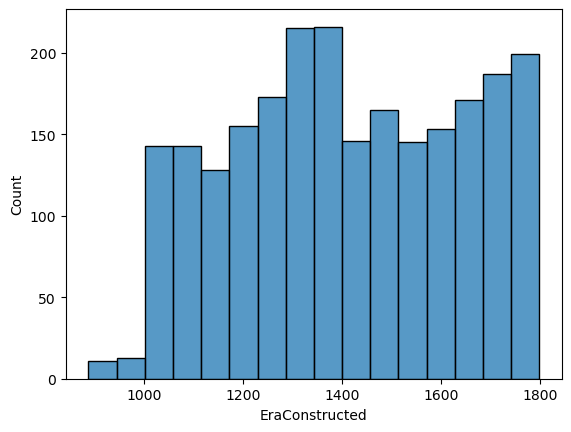

In [10]:
sns.histplot(set3_df['EraConstructed'])

<Axes: ylabel='EraConstructed'>

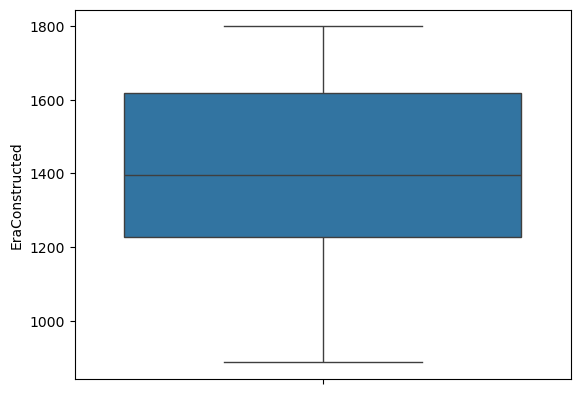

In [11]:
# Checking for outliers
sns.boxplot(set3_df['EraConstructed'])

<Axes: ylabel='Craftsmanship'>

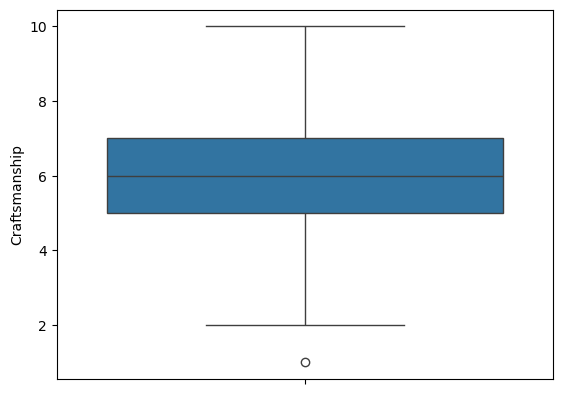

In [12]:
sns.boxplot(set3_df['Craftsmanship'])

In [13]:
from scipy.stats import zscore

z_scores = set3_df[['EraConstructed', 'Craftsmanship']].apply(zscore)
outliers = (z_scores.abs() > 3).sum()
print("Outliers per column:\n", outliers)

Outliers per column:
 EraConstructed    0
Craftsmanship     1
dtype: int64


In [6]:
# Mean, median and mode values for numeric rows
meanCraftsmanship = str(set3_df['Craftsmanship'].mean())
medianCraftsmanship = str(set3_df['Craftsmanship'].median())
modeCraftsmanship = str(set3_df['Craftsmanship'].mode().squeeze())

meanEraConstructed = str(set3_df['EraConstructed'].mean())
medianEraConstructed = str(set3_df['EraConstructed'].median())
modeEraConstructed = str(set3_df['EraConstructed'].mode().squeeze())

print(f"""
Mean Values:
Craftsmanship: {meanCraftsmanship}
Era Constructed: {meanEraConstructed}

Median Values:
Craftsmanship: {medianCraftsmanship}
Era Constructed: {medianEraConstructed}

Mode Values
Craftsmanship: {modeCraftsmanship}
Era Constructed: {modeEraConstructed}
""")


Mean Values:
Craftsmanship: 6.115107913669065
Era Constructed: 1409.8764282691493

Median Values:
Craftsmanship: 6.0
Era Constructed: 1396.0

Mode Values
Craftsmanship: 5
Era Constructed: 1313



## Data Preperation

In [16]:
# removes the duplicate rows in place
set3_df.drop_duplicates(inplace=True)

set3_df.dropna()

,DI,Craftsmanship,EraConstructed
0,0,5,1466
1,1,8,1411
2,2,7,1713
3,3,5,1296
4,4,7,1342
...,...,...,...
2358,2335,6,1284
2359,2336,4,1014
2360,2337,9,1784
2361,2338,5,1261


In [17]:
set3_df.describe()


,DI,Craftsmanship,EraConstructed
count,2340.000000,2340.000000,2340.000000
mean,1169.500000,6.119658,1409.779487
std,675.644137,1.410656,231.831135
min,0.000000,1.000000,887.000000
25%,584.750000,5.000000,1226.750000
50%,1169.500000,6.000000,1396.000000
75%,1754.250000,7.000000,1618.000000
max,2339.000000,10.000000,1799.000000


In [18]:
# Merge the second dataset with the third one
df = set2_df.merge(set3_df, left_on='DI', right_on='DI')


In [19]:
# Drop duplicates if there are any
df.drop_duplicates(inplace=True)

# Check if the merge was succesfull 
print(df.duplicated('DI').sum()) 

print("set2 shape:", set2_df.shape)
print("set3 shape:", set3_df.shape)
print("merged shape:", df.shape)

# Save the data for the moment to check manuall check
df.to_csv('set9_it3CHECK.csv', index=False)

0
set2 shape: (2204, 10)
set3 shape: (2340, 3)
merged shape: (2204, 12)


In [20]:
# Transforming ExteriorCharm to an Ordinal level of measurements 
sortedCharms = list(df.groupby('ExteriorCharm')['TradeValue'].mean().sort_values().index)

df['ExteriorCharm'] = df['ExteriorCharm'].map(lambda x: sortedCharms.index(x))
df['RealmType'].unique()

array(['Meadowlands', 'GnomeBurough', 'ArcaneMarket', 'AetherIsles',
       'CitadelQuarter'], dtype=object)

Removing outliers based for TradeValues
- Only benificial for linear regression 

In [21]:
Q1 = df['TradeValue'].quantile(0.25)
Q3 = df['TradeValue'].quantile(0.75)
median = df['TradeValue'].quantile(0.5)
IQR = Q3 - Q1
lr_df = df.copy()

lr_df.drop(df[df['TradeValue'] < Q1-(IQR*1.5) ].index, inplace=True)
lr_df.drop(df[df['TradeValue'] > Q3+(IQR*1.5) ].index, inplace=True)
df.describe()

,DI,TradeValue,LivingQuarters,ParcelSize,StructuralIntegrity,ExteriorCharm,AffordableDwelling,Craftsmanship,EraConstructed
count,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000
mean,1169.961434,181912.298094,1154.966878,936.214133,5.563521,1.404719,0.749546,6.119328,1411.337114
std,677.167198,81657.825404,393.563694,675.285369,1.093477,0.584639,0.433373,1.406750,229.844895
min,0.000000,12789.000000,256.000000,136.567410,1.000000,0.000000,0.000000,1.000000,887.000000
25%,583.750000,129975.000000,866.000000,689.688646,5.000000,1.000000,0.000000,5.000000,1231.750000
50%,1171.500000,160500.000000,1111.500000,870.965625,5.000000,1.000000,1.000000,6.000000,1396.000000
75%,1756.250000,213000.000000,1336.000000,1070.381914,6.000000,2.000000,1.000000,7.000000,1618.000000
max,2339.000000,755000.000000,4339.000000,15297.407980,9.000000,3.000000,1.000000,10.000000,1799.000000


## Data Correlation

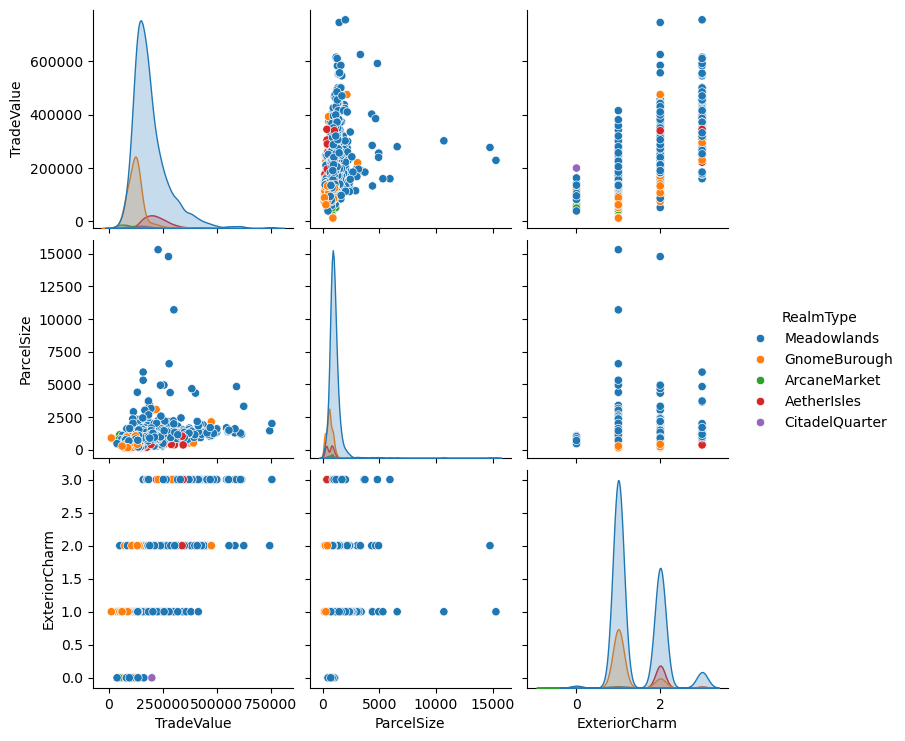

In [22]:
# Pairplot
sns.pairplot(df[['TradeValue','RealmType','ParcelSize','ExteriorCharm']],hue='RealmType')
# plt.savefig("pairplot.png")

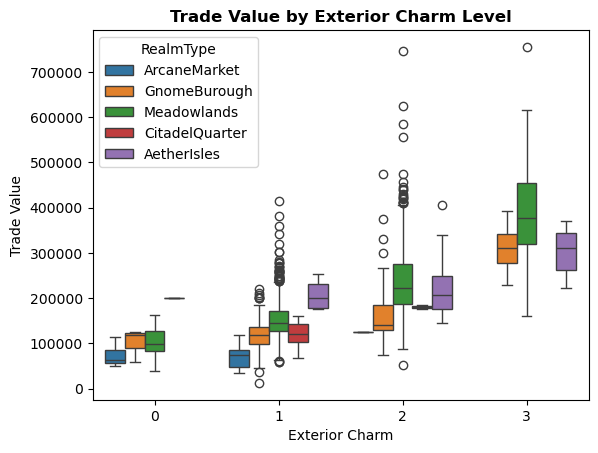

In [39]:
sns.boxplot(
    data=df,
    x='ExteriorCharm',
    y='TradeValue',
    hue='RealmType',
)

plt.title("Trade Value by Exterior Charm Level", fontweight='bold')
plt.xlabel("Exterior Charm")
plt.ylabel("Trade Value")
plt.show()

<Axes: >

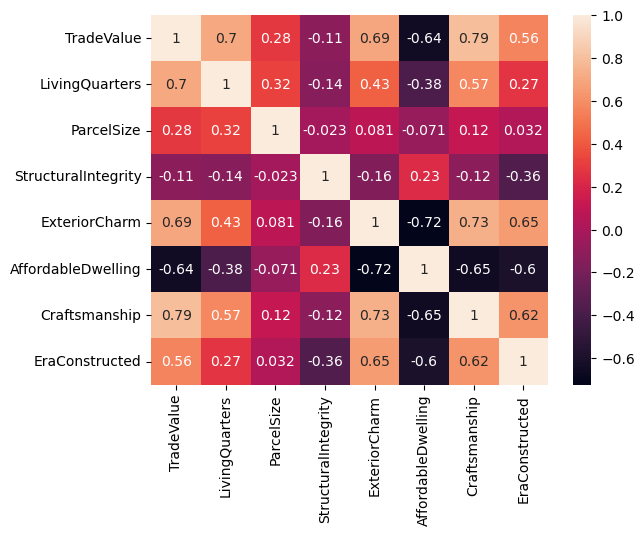

In [24]:
# Numeric correlations heatmap
sns.heatmap(
	df.filter(items=[col for col in df.columns if col not in ['RealmType','Enclave','ParcelSizeUnit','DI',]]).corr(),
	annot=True
	)
# plt.savefig("heatmap.png", bbox_inches='tight')

## Modeling

## Regression modeling

In [25]:

linear_model = LinearRegression()

X = lr_df[['TradeValue']]
y = lr_df[['Craftsmanship', 'ExteriorCharm', 'EraConstructed']]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=0)

linear_model.fit(X_train, y_train)

y_preds = linear_model.predict(X_valid)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_valid, y_preds))

Mean squared error: 12099.79


## Cross Validation for a linear regression model

In [26]:
from sklearn.model_selection import cross_val_score

scores = -1 * cross_val_score(linear_model, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Average MAE score:", scores.mean())

scores = -1 * cross_val_score(linear_model, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error')

print("Average MSE score:", scores.mean())

Average MAE score: 48.553018876835836
Average MSE score: 11008.39433549407


## Classfication modeling

Index(['TradeValue', 'LivingQuarters', 'ExteriorCharm', 'AffordableDwelling',
       'Craftsmanship'],
      dtype='object')


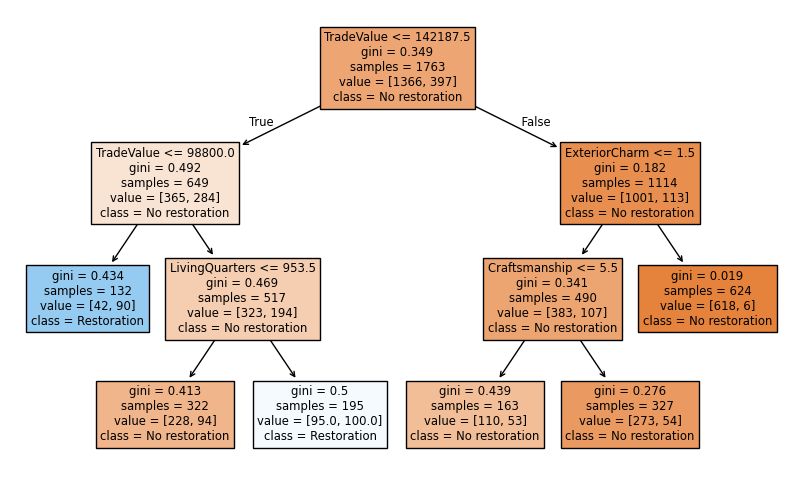

In [27]:
# for classifcation
def calculate_needs_restoration(row):
    age_factor = 1 if row['EraConstructed'] < 1300 else 0 
    structure_factor = 1 if row['StructuralIntegrity'] <= 6 else 0
    total_factors = age_factor + structure_factor
    return True if total_factors >= 2 else False

df["NeedsRestoration"] = df.apply(calculate_needs_restoration, axis=1)

features = df.filter(items=[col for col in df.columns if col not in ["ParcelSize","EraConstructed","StructuralIntegrity","RealmType","Enclave","ParcelSizeUnit","NeedsRestoration","DI"]])
print(features.columns)

X_train, X_test,y_train, y_test = train_test_split(features,df['NeedsRestoration'], test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(max_depth=3,
        min_samples_split  = 10,
        min_samples_leaf = 5,
        max_leaf_nodes =6 
)
clf.fit(X_train,y_train)

plt.figure(figsize=(10,6))
plot_tree(clf, feature_names=features.columns, class_names=['No restoration', 'Restoration'], filled=True)
plt.show()
y_pred = clf.predict(X_test)

## Evaluation with cross validation

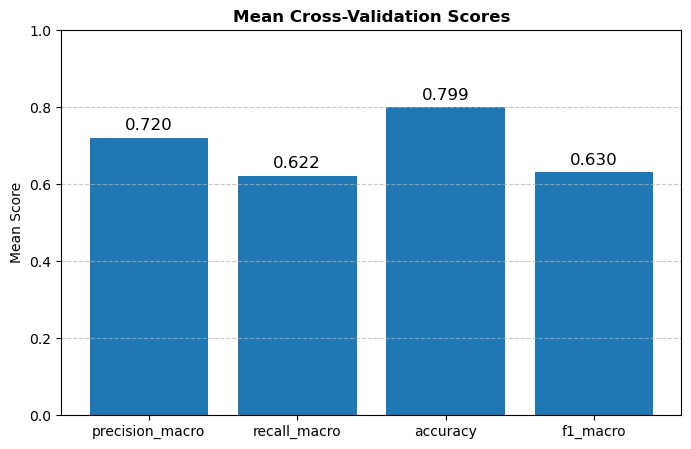

In [41]:
from sklearn.model_selection import cross_validate

scoring = ['precision_macro', 'recall_macro','accuracy','f1_macro']
scores = cross_validate(clf, features, df['NeedsRestoration'], scoring=scoring)

mean_scores = {key: np.mean(value) for key, value in scores.items() if key.startswith('test_')}
mean_scores = {key.replace("test_", ""): value for key, value in mean_scores.items()}

# Visualization
plt.figure(figsize=(8, 5))
plt.bar(mean_scores.keys(), mean_scores.values())
plt.ylim(0, 1)
plt.ylabel("Mean Score")
plt.title("Mean Cross-Validation Scores", fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show values on bars
for i, (metric, score) in enumerate(mean_scores.items()):
    plt.text(i, score + 0.02, f"{score:.3f}", ha='center', fontsize=12)

plt.show()

# Evaluation on single test split

In [29]:

# Predicted values from test_set
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
total = len(y_test)

# Compute metrics
error_rate = (FP + FN) / total
accuracy = (TP + TN) / total
true_positive_rate = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
true_negative_rate = TN / (TN + FP) if (TN + FP) > 0 else 0
positive_predictive_value = TP / (TP + FP) if (TP + FP) > 0 else 0

# Print results
print(f"Confusion Matrix:\n{cm}")
print(f"Total Instances: {total}")
print(f"False Negatives: {FN}")
print(f"False Possitives: {FP}")
print(f"Error Rate (Misclassification Rate): {error_rate:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (TPR / Recall): {true_positive_rate:.4f}")
print(f"True Negative Rate (TNR / Specificity): {true_negative_rate:.4f}")
print(f"Positive Predictive Value (PPV / Precision): {positive_predictive_value:.4f}")


Confusion Matrix:
[[325  29]
 [ 47  40]]
Total Instances: 441
False Negatives: 47
False Possitives: 29
Error Rate (Misclassification Rate): 0.1723
Accuracy: 0.8277
True Positive Rate (TPR / Recall): 0.4598
True Negative Rate (TNR / Specificity): 0.9181
Positive Predictive Value (PPV / Precision): 0.5797


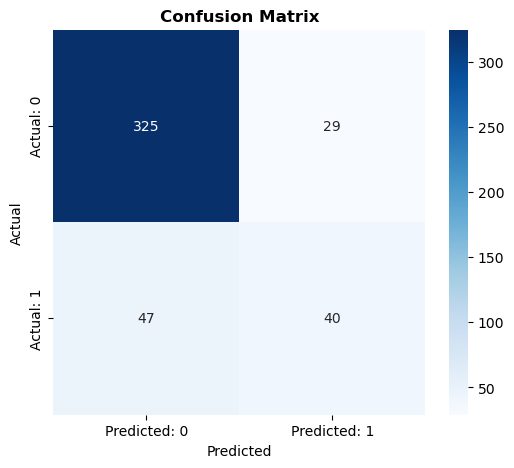

In [42]:
# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted: 0', 'Predicted: 1'], 
            yticklabels=['Actual: 0', 'Actual: 1'])

plt.title('Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()